Підключення бібліотек

In [106]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from datetime import datetime, date
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

Задаємо випадкове число для моделі нижче

In [107]:
random_state = np.random.RandomState(42)

Считування файлу CSV і перед його обробкою (перетворення всіх типів даних у числові та заповнення Nan значень) також задається довжина "життя" облікового запису. Для навчання ми віднімаємо не за допомогою сьогоднішньої дати, а за датою останнього зареєстрованого облікового запису

In [108]:
dataset_comp = pd.read_csv('TEST TASK (dataset).csv')

In [109]:
today = pd.to_datetime('2022-01-31')
dataset_comp['install_date'] = dataset_comp['install_date'].apply(lambda x: (today - datetime.strptime(x, '%Y-%m-%d')).days)
dataset_comp['media_source'] = dataset_comp['media_source'].apply(lambda x: int(x.replace('SOURCE_', '')))
dataset_comp['country_code'] = dataset_comp['country_code'].apply(lambda x: int(x.replace('COUNTRY_', '')))
dataset_comp['platform'] = dataset_comp['platform'].map({'ios': 1, 'android': 0})

In [110]:
dataset_comp = dataset_comp.fillna(0)

Для значного навчання беремо акаунти, які були зареэстровані більше 30 днів

In [111]:
dataset_comp_test = dataset_comp[dataset_comp['install_date'] >= 30]

Модель не може спрогнозувати відсутність прибутку тому, що  якщо гравець грає з вимкненим інтернетом , ніяких показників немає

In [112]:
data_0_target_smoll = dataset_comp_test[dataset_comp_test['target_full_ltv_day30'] != 0]

Модель для пошуку шумів, викидів та інших аномальних значень

In [113]:
model=IsolationForest(max_samples='auto',contamination='auto',random_state=random_state, n_jobs=-1, bootstrap=True, max_features=1, n_estimators=100, warm_start=True)

model.fit(data_0_target_smoll)

print(model.get_params())

{'bootstrap': True, 'contamination': 'auto', 'max_features': 1, 'max_samples': 'auto', 'n_estimators': 100, 'n_jobs': -1, 'random_state': RandomState(MT19937) at 0x1B410B3B840, 'verbose': 0, 'warm_start': True}


In [114]:
data_0_target_smoll_score = model.decision_function(data_0_target_smoll)

data_0_target_smoll_anomaly_score = model.predict(data_0_target_smoll)

print(data_0_target_smoll_score, data_0_target_smoll_anomaly_score)

[ 0.01271844  0.01012869  0.0133952  ... -0.03757273 -0.15148419
 -0.06561373] [ 1  1  1 ... -1 -1 -1]


Беремо дані, які модель вважає за шуми 

In [115]:
data_1 = data_0_target_smoll[data_0_target_smoll_score >= 0]

In [116]:
data_1

,total_sessions_day0,total_sessions_day1,total_sessions_day3,total_sessions_day7,chapters_finished_day0,chapters_finished_day1,chapters_finished_day3,chapters_finished_day7,chapters_opened_day0,chapters_opened_day1,chapters_opened_day3,chapters_opened_day7,chapters_closed_day0,chapters_closed_day1,chapters_closed_day3,chapters_closed_day7,diamonds_received_day0,diamonds_received_day1,diamonds_received_day3,diamonds_received_day7,diamonds_spent_day0,diamonds_spent_day1,diamonds_spent_day3,diamonds_spent_day7,tickets_spent_day0,tickets_spent_day1,tickets_spent_day3,tickets_spent_day7,retained_day1,retained_day3,retained_day7,chapters_finished_session1,chapters_finished_session3,chapters_finished_session9,chapters_opened_session1,chapters_opened_session3,chapters_opened_session9,chapters_closed_session1,chapters_closed_session3,chapters_closed_session9,diamonds_spent_session1,diamonds_spent_session3,diamonds_spent_session9,tickets_spent_session1,tickets_spent_session3,tickets_spent_session9,app_sub_ltv_day0,app_sub_ltv_day1,app_sub_ltv_day3,app_iap_ltv_day0,app_iap_ltv_day1,app_iap_ltv_day3,media_source,install_date,country_code,ad_ltv_day0,ad_ltv_day1,ad_ltv_day3,platform,target_sub_ltv_day30,target_iap_ltv_day30,target_ad_ltv_day30,target_full_ltv_day30
85,1.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,23,59,203,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.007280,0.007280
184,1.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,2,59,218,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.023615,0.023615
324,1.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.000000,0.000000,2.157594,2.157594,23,59,141,0.000000,0.000000,0.000000,1,0.000000,2.157594,0.000000,2.157594
514,1.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.000000,0.000000,0.389298,0.389298,17,59,141,0.000000,0.000000,0.000000,1,0.000000,0.389298,0.000000,0.389298
609,1.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,27,27,27,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,23,59,141,0.000000,0.000000,0.000000,1,0.000000,0.000000,0.012868,0.012868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1467575,7.0,7.0,8.0,8.0,7,7,7,7,8,8,8,8,1,1,1,1,197,197,197,197,193,193,193,193,6,6,6,6,0,0,0,0,1,7,1,2,8,0,0,1,0,29,193,0,0,6,0.0,0.0,0.000000,2.443256,2.443256,2.443256,17,32,155,0.065278,0.065278,0.065278,1,0.000000,2.443256,0.065278,2.508534
1467594,2.0,2.0,2.0,2.0,5,5,5,5,5,5,5,5,0,0,0,0,230,230,230,230,196,196,196,196,4,4,4,4,0,0,0,0,5,5,1,5,5,0,0,0,0,196,196,0,4,4,0.0,0.0,0.000000,2.037775,2.037775,2.037775,17,32,8,0.000000,0.000000,0.000000,1,0.000000,2.037775,0.000000,2.037775
1467637,8.0,8.0,8.0,8.0,4,4,4,4,4,4,4,4,1,1,1,1,341,341,341,341,203,203,203,203,3,3,3,3,0,0,0,0,1,4,1,2,4,0,0,1,29,53,203,0,1,3,0.0,0.0,0.000000,3.497514,3.497514,3.497514,17,32,141,0.000000,0.000000,0.000000,1,0.000000,3.497514,0.000000,3.497514
1467670,6.0,6.0,6.0,6.0,4,4,4,4,5,5,5,5,1,1,1,1,338,338,338,338,210,210,210,210,3,3,3,3,0,0,0,0,3,4,1,3,5,0,0,1,0,152,210,0,3,3,0.0,0.0,0.933867,3.114970,3.114970,3.114970,23,32,141,0.000000,0.000000,0.000000,1,4.669336,3.114970,0.000000,7.784306


Переглядаємо важливість колонокок після пошуку шумів 

In [119]:
data_1_0 = data_1.copy()
labl = data_1_0.pop('target_full_ltv_day30')
data_1_0.drop(['target_sub_ltv_day30', 'target_iap_ltv_day30', 'target_ad_ltv_day30'], axis=1)

,total_sessions_day0,total_sessions_day1,total_sessions_day3,total_sessions_day7,chapters_finished_day0,chapters_finished_day1,chapters_finished_day3,chapters_finished_day7,chapters_opened_day0,chapters_opened_day1,chapters_opened_day3,chapters_opened_day7,chapters_closed_day0,chapters_closed_day1,chapters_closed_day3,chapters_closed_day7,diamonds_received_day0,diamonds_received_day1,diamonds_received_day3,diamonds_received_day7,diamonds_spent_day0,diamonds_spent_day1,diamonds_spent_day3,diamonds_spent_day7,tickets_spent_day0,tickets_spent_day1,tickets_spent_day3,tickets_spent_day7,retained_day1,retained_day3,retained_day7,chapters_finished_session1,chapters_finished_session3,chapters_finished_session9,chapters_opened_session1,chapters_opened_session3,chapters_opened_session9,chapters_closed_session1,chapters_closed_session3,chapters_closed_session9,diamonds_spent_session1,diamonds_spent_session3,diamonds_spent_session9,tickets_spent_session1,tickets_spent_session3,tickets_spent_session9,app_sub_ltv_day0,app_sub_ltv_day1,app_sub_ltv_day3,app_iap_ltv_day0,app_iap_ltv_day1,app_iap_ltv_day3,media_source,install_date,country_code,ad_ltv_day0,ad_ltv_day1,ad_ltv_day3,platform
85,1.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,23,59,203,0.000000,0.000000,0.000000,0
184,1.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,2,59,218,0.000000,0.000000,0.000000,0
324,1.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.000000,0.000000,2.157594,2.157594,23,59,141,0.000000,0.000000,0.000000,1
514,1.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.000000,0.000000,0.389298,0.389298,17,59,141,0.000000,0.000000,0.000000,1
609,1.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,27,27,27,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,23,59,141,0.000000,0.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1467575,7.0,7.0,8.0,8.0,7,7,7,7,8,8,8,8,1,1,1,1,197,197,197,197,193,193,193,193,6,6,6,6,0,0,0,0,1,7,1,2,8,0,0,1,0,29,193,0,0,6,0.0,0.0,0.000000,2.443256,2.443256,2.443256,17,32,155,0.065278,0.065278,0.065278,1
1467594,2.0,2.0,2.0,2.0,5,5,5,5,5,5,5,5,0,0,0,0,230,230,230,230,196,196,196,196,4,4,4,4,0,0,0,0,5,5,1,5,5,0,0,0,0,196,196,0,4,4,0.0,0.0,0.000000,2.037775,2.037775,2.037775,17,32,8,0.000000,0.000000,0.000000,1
1467637,8.0,8.0,8.0,8.0,4,4,4,4,4,4,4,4,1,1,1,1,341,341,341,341,203,203,203,203,3,3,3,3,0,0,0,0,1,4,1,2,4,0,0,1,29,53,203,0,1,3,0.0,0.0,0.000000,3.497514,3.497514,3.497514,17,32,141,0.000000,0.000000,0.000000,1
1467670,6.0,6.0,6.0,6.0,4,4,4,4,5,5,5,5,1,1,1,1,338,338,338,338,210,210,210,210,3,3,3,3,0,0,0,0,3,4,1,3,5,0,0,1,0,152,210,0,3,3,0.0,0.0,0.933867,3.114970,3.114970,3.114970,23,32,141,0.000000,0.000000,0.000000,1


In [120]:
rf = RandomForestRegressor(n_estimators=150)
rf.fit(data_1_0, labl)

In [ ]:
sort = rf.feature_importances_.argsort()
plt.figure(figsize=(30, 30))
plt.barh(data_1_0.columns[sort], rf.feature_importances_[sort])
plt.xlabel("Feature Importance")

plt.show()

Як ми бачимо найбільш важливий параметр це app_iap_ltv_day3(накопичувальний дохід з внутрішньої ігрової суми на 3 дні), а також входять в нього параметри по отриманню і витрата алмазів, а ідуть app_sub_ltv_day3 і ad_ltv_day3 тому ми їх і передаємо в основну модель

Створюємо модель для визначення ступеня зацікавленості гравця
Берем усі параметри, що вказують на те, як саме грає гравець(як часто заходить, скільки проходить глави і т.д.)

In [ ]:
features_clusterization = data_1[['total_sessions_day0', 'total_sessions_day1', 'total_sessions_day3',
       'total_sessions_day7', 'chapters_finished_day0',
       'chapters_finished_day1', 'chapters_finished_day3',
       'chapters_finished_day7', 'chapters_opened_day0',
       'chapters_opened_day1', 'chapters_opened_day3', 'chapters_opened_day7',
       'chapters_closed_day0', 'chapters_closed_day1', 'chapters_closed_day3',
       'chapters_closed_day7', 'diamonds_received_day0',
       'diamonds_received_day1', 'diamonds_received_day3',
       'diamonds_received_day7', 'diamonds_spent_day0', 'diamonds_spent_day1',
       'diamonds_spent_day3', 'diamonds_spent_day7', 'tickets_spent_day0',
       'tickets_spent_day1', 'tickets_spent_day3', 'tickets_spent_day7',
       'retained_day1', 'retained_day3', 'retained_day7',
       'chapters_finished_session1', 'chapters_finished_session3',
       'chapters_finished_session9', 'chapters_opened_session1',
       'chapters_opened_session3', 'chapters_opened_session9',
       'chapters_closed_session1', 'chapters_closed_session3',
       'chapters_closed_session9', 'diamonds_spent_session1',
       'diamonds_spent_session3', 'diamonds_spent_session9',
       'tickets_spent_session1', 'tickets_spent_session3',
       'tickets_spent_session9']]

In [ ]:
spectral = KMeans()

In [ ]:
spectral.fit(features_clusterization)

KMeans()

In [ ]:
spectral_predict = spectral.predict(features_clusterization)

In [ ]:
len(spectral_predict)

175565

Створюємо дані та модель для прогнозування прибутку з гравця, передаємо параметри з 3 видами прибутку на 3 день і ступенем зацікавленості.

In [ ]:
data_ready = data_1[['app_sub_ltv_day3', 'app_iap_ltv_day3', 'ad_ltv_day3']]

In [ ]:
data_ready['interest_degree'] = spectral_predict

C:\Users\dskac\AppData\Local\Temp\ipykernel_5788\2234054796.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ready['interest_degree'] = spectral_predict


In [ ]:
labl = data_1.pop('target_full_ltv_day30')

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(data_ready, labl, test_size=0.2, random_state=0)

In [ ]:
forest = RandomForestRegressor()
pipeline_ready_m = make_pipeline(MinMaxScaler(), RandomForestRegressor(n_estimators=200))
pipeline_ready_m.fit(X_train, Y_train)
pred_forest = pipeline_ready_m.predict(X_test)

In [ ]:
print(mean_absolute_percentage_error(Y_test, pred_forest))
print(mean_absolute_error(Y_test, pred_forest))
print(mean_squared_error(Y_test, pred_forest))
pred_forest[40:50], Y_test[40:50]

8.559341858133532
0.18075742515903
1.0836217491848026


(array([1.05069907e+00, 3.53115849e-04, 5.65301370e-03, 6.30401132e-02,
        7.59225468e-03, 2.09035131e-02, 2.18355748e-03, 3.18206704e-02,
        1.28066742e-03, 1.14587581e-01]),
 1190098    1.051914
 805651     0.000296
 1191585    0.003267
 1461117    0.063035
 927117     0.006937
 195236     0.020903
 564480     0.002183
 1085576    0.005209
 1363733    0.000553
 819847     0.031168
 Name: target_full_ltv_day30, dtype: float64)

In [ ]:
from sklearn.metrics import r2_score
r2_score(Y_test, pred_forest)

0.3164445755403277

Як можна побачити на графіку нижче у нас НЕ всі викиди були прибрані моделлю для пошуку аномалій , а ті , що залишились , основна модель прогнозує погано 

<function matplotlib.pyplot.show(close=None, block=None)>

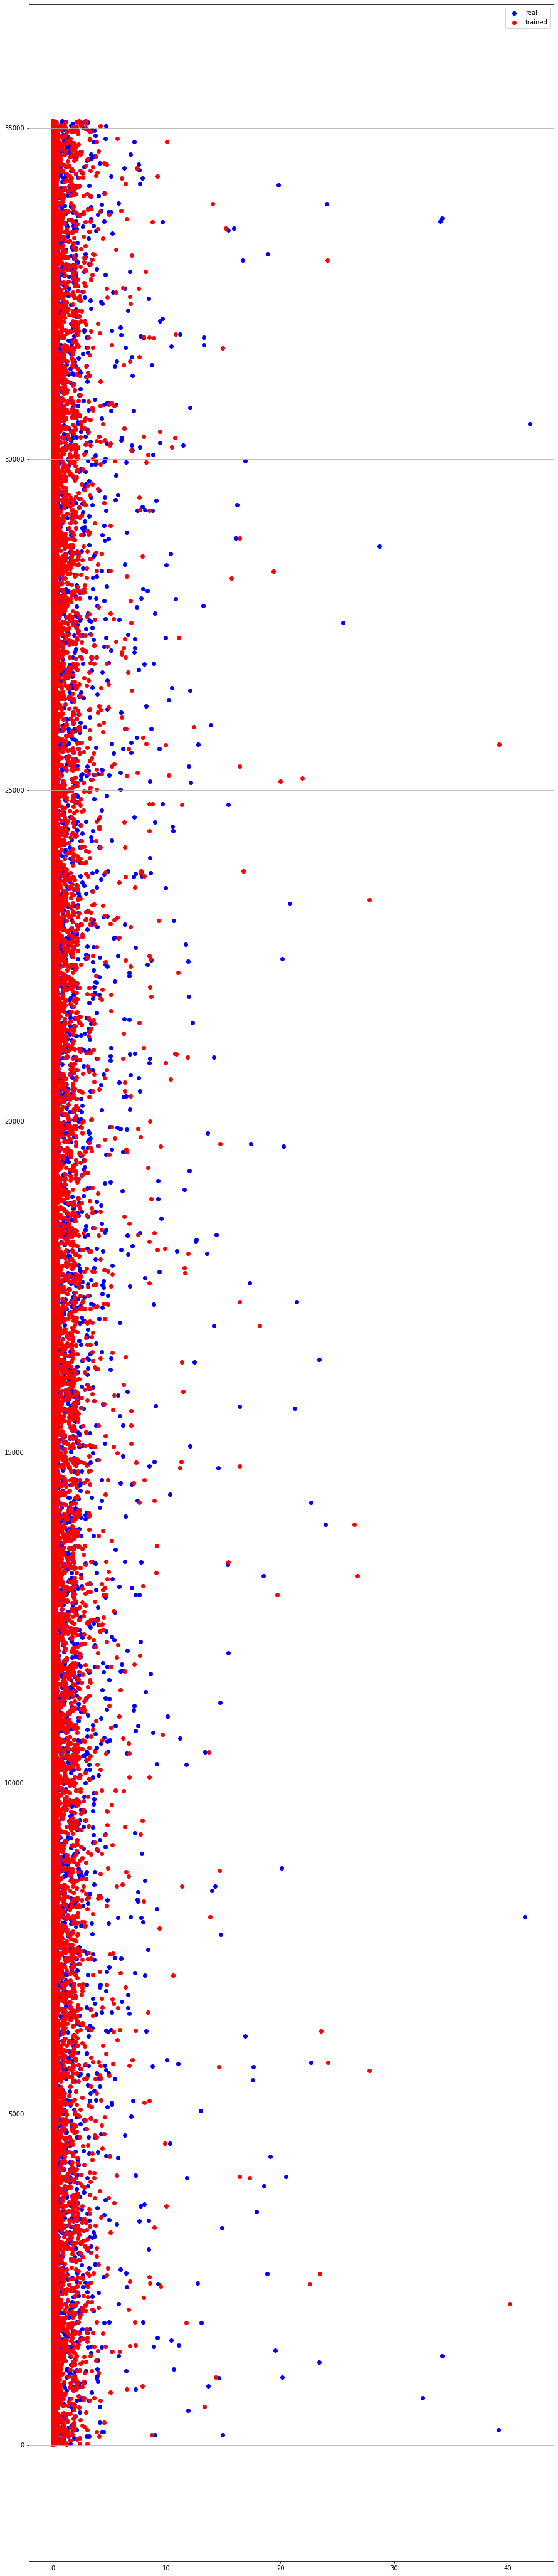

In [ ]:
plt.figure(figsize=(15, 75))
real = plt.scatter(Y_test, range(1, len(Y_test)+1), color='blue')
real.set_label('real')
trained = plt.scatter(pred_forest, range(1, len(pred_forest)+1), color='red')
trained.set_label('trained')
plt.grid(axis='y')
plt.legend()
plt.show